<a href="https://colab.research.google.com/github/kamalova/Capstone/blob/main/Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Data visualization
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
# Seaborn's beautiful styling
import seaborn as sns
# to get rid of the warnings
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
from collections import Counter
from scipy import stats

from scipy.linalg import sqrtm
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%rm -rf sample_data/

In [6]:
rec_df = pd.read_csv('/content/reviews_polarity.csv', usecols=['listing_id','reviewer_id','polarity'])
rec_df

,listing_id,reviewer_id,polarity
0,2595,38960,0.9274
1,2595,71130,0.9136
2,2595,117113,0.9409
3,2595,1783688,0.9863
4,2595,1870771,0.9542
...,...,...,...
70815,72265,109542482,0.7774
70816,72265,1282541,0.6249
70817,72265,8936723,0.9870
70818,72265,17160406,0.8126


#### Building Recommender System 

In [7]:
# create utility matrix

util_matrix = rec_df.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')
util_matrix

listing_id,2539,2595,3831,5121,5136,5178,5203,5295,5803,6848,...,144087,144148,148201,148259,148825,150804,150989,151199,152263,153780
reviewer_id,,,,,,,,,,,,,,,,,,,,,
357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409,NaN,NaN,NaN,NaN,NaN,0.8957,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467162104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468291841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470853708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# keep track of reviewers (users) and listings (items)

userrows = list(util_matrix.index)
users_index = {userrows[i]: i for i in range(len(userrows))}

itemcols = list(util_matrix.columns)
items_index = {itemcols[i]: i for i in range(len(itemcols))}

In [9]:
from scipy.sparse.linalg import svds

In [12]:

def recommend_predictions(df, k):
    """
    :param df_rec: dataframe with polarity values for known reviewer/listing pairs
    :param k: number of features to keep for SVD

    returns the dataframe with predicted polarity values for all (user,item) pairs
    """
    # get utility matrix
    util_matrix = df.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')

    # keep track of reviewers and listings
    reviewer_rows = list(util_matrix.index)
    reviewer_index = {reviewer_rows[i]: i for i in range(len(reviewer_rows))}
    listing_cols = list(util_matrix.columns)
    listing_index = {listing_cols[i]: i for i in range(len(listing_cols))}

    # mask NaN and remove means
    mask = np.isnan(util_matrix)
    masked_arr = np.ma.masked_array(util_matrix, mask)
    item_means = np.mean(masked_arr, axis=0) 
    util_matrix = masked_arr.filled(item_means)
    means = np.tile(item_means, (util_matrix.shape[0],1))
    util_mat_demeaned = util_matrix - means

    # run SVD
    u, sigma, vT = svds(util_mat_demeaned, k = k)
    sigma = np.diag(sigma)  
    predicted_polarity = np.dot(np.dot(u, sigma), vT) + means

    return predicted_polarity, reviewer_index, listing_index

In [13]:
pred,_,_ = recommend_predictions(rec_df, k=50)

In [14]:
# evaluate on known reviewer-listing pairs

this_pred = [] #to store the predicted ratings
for i, row in rec_df.iterrows():
    user = row['reviewer_id']
    item = row['listing_id']
    
    try:
        u_index = users_index[user]
        if item in items_index:
            i_index = items_index[item]
            pred_rating = pred[u_index, i_index]
        else:
            pred_rating = np.mean(svdout[u_index, :])
        this_pred.append(pred_rating)
        
    except:
        print('error with user', user, 'at index', i)

In [15]:
rmse = sqrt(mean_squared_error(rec_df['polarity'], this_pred))
print(rmse)

0.11964342556548616


Hyperparam optimization: k, the number of features into which each user and movie will be resolved into

In [16]:
# try different values of k

no_of_features = [80, 120, 150, 200]
rmse= []

for k in no_of_features:
    pred_out, _, _ = recommend_predictions(rec_df, k=k)
    
    this_pred = [] #to store the predicted ratings
    for i, row in rec_df.iterrows():
        user = row['reviewer_id']
        item = row['listing_id']

        try:
            u_index = users_index[user]
            if item in items_index:
                i_index = items_index[item]
                pred_rating = pred_out[u_index, i_index]
            else:
                pred_rating = np.mean(svdout[u_index, :])
            this_pred.append(pred_rating)

        except:
            print('error with user', user, 'at index', i)
            continue

    rmse_i = sqrt(mean_squared_error(rec_df['polarity'], this_pred))
    rmse.append(rmse_i)
    
    print(k, rmse_i)

80 0.09054374089580143
120 0.05928897460732444
150 0.04354203122834645
200 0.028019632928086877


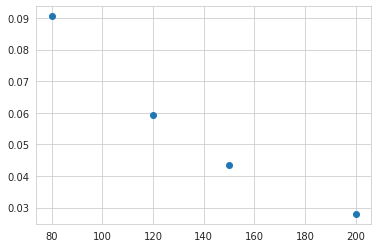

In [17]:
plt.scatter(no_of_features, rmse);

In [18]:
from math import sqrt
from IPython.display import clear_output
import timeit

In [27]:
def funkSVD(util_matrix, latent_features=100, learning_rate=0.0001, iters=100, plot=True, use_prev_train=False, 
            prev_train_reviewer=None, prev_train_listing=None):  
    """ 
    Estimates the full matrix of polarities for user/item pairs using an implementation of Simon Funk's SVD
    
    :param util_mat: utility matrix with reviewer and listing axes
    :param latent_features: k, number of selected features to keep
    :param learning_rate: learning rate for gradient descent
    :param iters: number of iterations
    :plot: bool, whether to plot progress of iter vs cost fct (RMSE)
    :use_prev_train: bool, whether to initialize reviewer and listing matrices with a previous round of training 
    :prev_train_reviewer: previous round's reviewer matrix
    :prev_train_listing: previous round's listing matrix
    
    returns full estimated matrix, and U (reviewers) and V (listings) matrices
    """
    
    start = timeit.default_timer()
    util_mat = np.matrix(util_matrix)
    n_reviewers = util_matrix.shape[0]
    n_listings = util_matrix.shape[1]
    
    # number of non-null polarity values we have (ie. known reviewer/listing polarity values)
    num_polarities = np.count_nonzero(~np.isnan(util_matrix))
    
    # if want to pick up training from last checkpoint
    if use_prev_train:
        reviewer_mat = prev_train_reviewer
        listing_mat = prev_train_listing
    else:
        # initialize the U and V matrices with random values in range -1 to 1 inclusive (polarity range)
        reviewer_mat = np.random.randint(-1, 2, size=(n_reviewers, latent_features)).astype(float)
        listing_mat = np.random.randint(-1, 2, size=(latent_features, n_listings)).astype(float)
    
    rmse_accum = 0
    rmse_list = []
    
    for iteration in range(iters):
        clear_output(wait=True)
        
        old_sse = rmse_accum
        rmse_accum = 0
        for i in range(n_reviewers):
            for j in range(n_listings):       
                # if polarity not nan
                if util_matrix[i, j] > 0:                   
                    # compute the error between actual polarity and current (from init rand) polarity
                    diff = util_matrix[i, j] - np.dot(reviewer_mat[i, :], listing_mat[:, j])
                    
                    # update RMSE
                    rmse_accum += sqrt(diff**2)
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        reviewer_mat[i, k] += learning_rate * (2*diff*listing_mat[k, j])
                        listing_mat[k, j] += learning_rate * (2*diff*reviewer_mat[i, k])
        
        rmse_list.append( rmse_accum / num_polarities )
        stop = timeit.default_timer()
        
        # print results for iteration
        print("Current iteration: %d, RMSE: %f" % (iteration+1, rmse_accum / num_polarities)),
        print("Current run time: %f minutes" % ((stop-start)/60))
        
        if plot:
            plt.figure()
            plt.scatter(np.arange(iteration+1), rmse_list)
            plt.plot(np.arange(iteration+1), rmse_list)
            plt.xlabel('iteration')
            plt.ylabel('RMSE');
            #plt.pause(1);
    
    # get full matrix as dot product of U and V
    full_mat = np.dot(reviewer_mat, listing_mat)
        
    return full_mat, reviewer_mat, listing_mat 

In [28]:
# matrix -> the utility matrix calculated in previous section

funk_full_mat, reviewer_mat, listing_mat = funkSVD(util_matrix, latent_features=50, learning_rate=0.001)

KeyError: ignored